In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ = pd.read_csv("https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv", index_col=0)
df_.head()

,全国地方公共団体コード,都道府県名,市区町村名,公表_年月日,曜日,発症_年月日,患者_居住地,患者_年代,患者_性別,患者_属性,患者_状態,患者_症状,患者_渡航歴の有無フラグ,備考,退院済フラグ
No,,,,,,,,,,,,,,,
1,130001,東京都,NaN,2020-01-24,金,NaN,湖北省武漢市,40代,男性,NaN,NaN,NaN,NaN,NaN,1.0
2,130001,東京都,NaN,2020-01-25,土,NaN,湖北省武漢市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
3,130001,東京都,NaN,2020-01-30,木,NaN,湖南省長沙市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
4,130001,東京都,NaN,2020-02-13,木,NaN,都内,70代,男性,NaN,NaN,NaN,NaN,NaN,NaN
5,130001,東京都,NaN,2020-02-14,金,NaN,都内,50代,女性,NaN,NaN,NaN,NaN,NaN,1.0


In [3]:
# 年月日で集計
s = df_['公表_年月日'].value_counts().sort_index()

df = pd.DataFrame({'date':pd.to_datetime(s.index), 'confirmed':s})

# 報告がない日は0埋めしておく
df = pd.merge(pd.DataFrame({'date': pd.date_range(df.iloc[0]['date'],
                                                  df.iloc[-1]['date'])}),
              df, how='left')
df['confirmed'] = df['confirmed'].fillna(0)
df = df.set_index('date', drop=False)

df.head()

,date,confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,1.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0


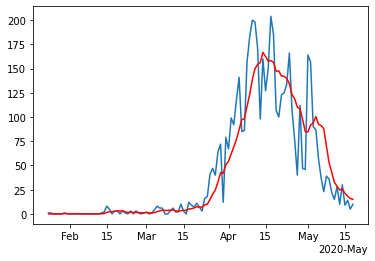

In [4]:
# 感染者数の推移をプロット

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.clear()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df['date'], df['confirmed'])

# 移動平均をプロット
rm = df['confirmed'].rolling(7).mean().fillna(0)
ax.plot(df['date'], rm, 'r')

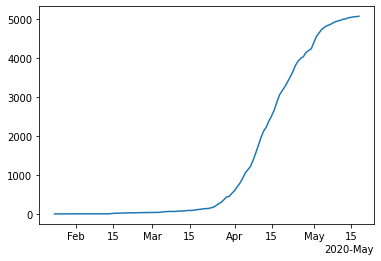

In [5]:
# 感染者数の累計をプロット

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.clear()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df['date'], df['confirmed'].cumsum())

In [6]:
# AICが最小となるSARIMAモデルをグリッドサーチ

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

best_fit = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['confirmed'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if best_fit == None:
                best_fit = results
            elif results.aic < best_fit.aic:
                best_fit = results
        except: 
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 7) - AIC:1316.7891065224526
SARIMAX(0, 0, 0)x(0, 0, 1, 7) - AIC:1167.042751899524
SARIMAX(0, 0, 0)x(0, 0, 2, 7) - AIC:1051.958457185309
SARIMAX(0, 0, 0)x(0, 1, 0, 7) - AIC:1097.609536312152
SARIMAX(0, 0, 0)x(0, 1, 1, 7) - AIC:1033.761072370462
SARIMAX(0, 0, 0)x(0, 1, 2, 7) - AIC:963.1354058568807
SARIMAX(0, 0, 0)x(0, 2, 0, 7) - AIC:1086.2164615692739
SARIMAX(0, 0, 0)x(0, 2, 1, 7) - AIC:983.7421914284268
SARIMAX(0, 0, 0)x(0, 2, 2, 7) - AIC:916.9942039185729
SARIMAX(0, 0, 0)x(1, 0, 0, 7) - AIC:1101.6328839932194
SARIMAX(0, 0, 0)x(1, 0, 1, 7) - AIC:1091.3354309958352
SARIMAX(0, 0, 0)x(1, 0, 2, 7) - AIC:1018.067405832393
SARIMAX(0, 0, 0)x(1, 1, 0, 7) - AIC:1042.329272183464
SARIMAX(0, 0, 0)x(1, 1, 1, 7) - AIC:1034.6770207718146
SARIMAX(0, 0, 0)x(1, 1, 2, 7) - AIC:964.9144969997157
SARIMAX(0, 0, 0)x(1, 2, 0, 7) - AIC:991.0953415347194
SARIMAX(0, 0, 0)x(1, 2, 1, 7) - AIC:983.6960298630368
SARIMAX(0, 0, 0)x(1, 2, 2, 7) - AIC:918.6869495098222
SARIMAX(0, 0, 0)x(2, 0,

SARIMAX(0, 1, 2)x(1, 2, 2, 7) - AIC:827.0426329783174
SARIMAX(0, 1, 2)x(2, 0, 0, 7) - AIC:935.7223734756196
SARIMAX(0, 1, 2)x(2, 0, 1, 7) - AIC:933.0752135056638
SARIMAX(0, 1, 2)x(2, 0, 2, 7) - AIC:908.9832122757921
SARIMAX(0, 1, 2)x(2, 1, 0, 7) - AIC:890.6429486687816
SARIMAX(0, 1, 2)x(2, 1, 1, 7) - AIC:891.5176233936593
SARIMAX(0, 1, 2)x(2, 1, 2, 7) - AIC:860.5005925809562
SARIMAX(0, 1, 2)x(2, 2, 0, 7) - AIC:860.3515612086752
SARIMAX(0, 1, 2)x(2, 2, 1, 7) - AIC:846.7469396233987
SARIMAX(0, 1, 2)x(2, 2, 2, 7) - AIC:820.3907790134358
SARIMAX(0, 2, 0)x(0, 0, 0, 7) - AIC:1162.67851724826
SARIMAX(0, 2, 0)x(0, 0, 1, 7) - AIC:1097.7711451950534
SARIMAX(0, 2, 0)x(0, 0, 2, 7) - AIC:1011.7447215042221
SARIMAX(0, 2, 0)x(0, 1, 0, 7) - AIC:1148.5724877312314
SARIMAX(0, 2, 0)x(0, 1, 1, 7) - AIC:1031.3869071138463
SARIMAX(0, 2, 0)x(0, 1, 2, 7) - AIC:967.1140441063923
SARIMAX(0, 2, 0)x(0, 2, 0, 7) - AIC:1195.8467882123489
SARIMAX(0, 2, 0)x(0, 2, 1, 7) - AIC:1025.846960545707
SARIMAX(0, 2, 0)x(0, 2, 

SARIMAX(1, 0, 2)x(0, 2, 1, 7) - AIC:912.2517973193155
SARIMAX(1, 0, 2)x(0, 2, 2, 7) - AIC:834.9680466737595
SARIMAX(1, 0, 2)x(1, 0, 0, 7) - AIC:1002.2681561594212
SARIMAX(1, 0, 2)x(1, 0, 1, 7) - AIC:984.3467348187681
SARIMAX(1, 0, 2)x(1, 0, 2, 7) - AIC:919.1965050536731
SARIMAX(1, 0, 2)x(1, 1, 0, 7) - AIC:948.3830138094352
SARIMAX(1, 0, 2)x(1, 1, 1, 7) - AIC:936.1390828708273
SARIMAX(1, 0, 2)x(1, 1, 2, 7) - AIC:874.7616417363705
SARIMAX(1, 0, 2)x(1, 2, 0, 7) - AIC:920.8500847148159
SARIMAX(1, 0, 2)x(1, 2, 1, 7) - AIC:892.2398824803031
SARIMAX(1, 0, 2)x(1, 2, 2, 7) - AIC:827.7761525767297
SARIMAX(1, 0, 2)x(2, 0, 0, 7) - AIC:936.2508718757487
SARIMAX(1, 0, 2)x(2, 0, 1, 7) - AIC:933.5422007090112
SARIMAX(1, 0, 2)x(2, 0, 2, 7) - AIC:917.9026083081787
SARIMAX(1, 0, 2)x(2, 1, 0, 7) - AIC:891.1063222897648
SARIMAX(1, 0, 2)x(2, 1, 1, 7) - AIC:891.9017202684225
SARIMAX(1, 0, 2)x(2, 1, 2, 7) - AIC:869.4041070066833
SARIMAX(1, 0, 2)x(2, 2, 0, 7) - AIC:858.8130198103636
SARIMAX(1, 0, 2)x(2, 2, 1, 

SARIMAX(1, 2, 1)x(2, 2, 0, 7) - AIC:854.8995250099296
SARIMAX(1, 2, 1)x(2, 2, 1, 7) - AIC:843.7921735137605
SARIMAX(1, 2, 1)x(2, 2, 2, 7) - AIC:840.2607183109102
SARIMAX(1, 2, 2)x(0, 0, 0, 7) - AIC:1056.1472714587117
SARIMAX(1, 2, 2)x(0, 0, 1, 7) - AIC:989.1770712238398
SARIMAX(1, 2, 2)x(0, 0, 2, 7) - AIC:914.0911866849528
SARIMAX(1, 2, 2)x(0, 1, 0, 7) - AIC:1009.7157978283535
SARIMAX(1, 2, 2)x(0, 1, 1, 7) - AIC:922.0310962260023
SARIMAX(1, 2, 2)x(0, 1, 2, 7) - AIC:864.511275650059
SARIMAX(1, 2, 2)x(0, 2, 0, 7) - AIC:1050.5450889886538
SARIMAX(1, 2, 2)x(0, 2, 1, 7) - AIC:904.7250634617858
SARIMAX(1, 2, 2)x(0, 2, 2, 7) - AIC:822.7699198181325
SARIMAX(1, 2, 2)x(1, 0, 0, 7) - AIC:999.5933504887558
SARIMAX(1, 2, 2)x(1, 0, 1, 7) - AIC:981.1521456073417
SARIMAX(1, 2, 2)x(1, 0, 2, 7) - AIC:915.6649622624623
SARIMAX(1, 2, 2)x(1, 1, 0, 7) - AIC:940.4147286520072
SARIMAX(1, 2, 2)x(1, 1, 1, 7) - AIC:923.2223014876517
SARIMAX(1, 2, 2)x(1, 1, 2, 7) - AIC:864.3807219503863
SARIMAX(1, 2, 2)x(1, 2, 0,

SARIMAX(2, 1, 1)x(1, 1, 2, 7) - AIC:874.8866791755466
SARIMAX(2, 1, 1)x(1, 2, 0, 7) - AIC:908.174230860128
SARIMAX(2, 1, 1)x(1, 2, 1, 7) - AIC:902.3282398560654
SARIMAX(2, 1, 1)x(1, 2, 2, 7) - AIC:838.1419282665628
SARIMAX(2, 1, 1)x(2, 0, 0, 7) - AIC:920.7699840963099
SARIMAX(2, 1, 1)x(2, 0, 1, 7) - AIC:918.7206984699764
SARIMAX(2, 1, 1)x(2, 0, 2, 7) - AIC:919.8761124721575
SARIMAX(2, 1, 1)x(2, 1, 0, 7) - AIC:874.5810686257373
SARIMAX(2, 1, 1)x(2, 1, 1, 7) - AIC:875.9166407439735
SARIMAX(2, 1, 1)x(2, 1, 2, 7) - AIC:870.4340440451625
SARIMAX(2, 1, 1)x(2, 2, 0, 7) - AIC:843.0360710879984
SARIMAX(2, 1, 1)x(2, 2, 1, 7) - AIC:838.972278181624
SARIMAX(2, 1, 1)x(2, 2, 2, 7) - AIC:830.5655796703809
SARIMAX(2, 1, 2)x(0, 0, 0, 7) - AIC:1050.3253126783088
SARIMAX(2, 1, 2)x(0, 0, 1, 7) - AIC:987.4511068183987
SARIMAX(2, 1, 2)x(0, 0, 2, 7) - AIC:912.5457956566673
SARIMAX(2, 1, 2)x(0, 1, 0, 7) - AIC:1007.3481692647215
SARIMAX(2, 1, 2)x(0, 1, 1, 7) - AIC:928.3366595859977
SARIMAX(2, 1, 2)x(0, 1, 2, 7

In [7]:
print(best_fit.summary().tables[0])

                                 Statespace Model Results                                
Dep. Variable:                         confirmed   No. Observations:                  116
Model:             SARIMAX(2, 2, 2)x(1, 2, 2, 7)   Log Likelihood                -400.739
Date:                           Mon, 18 May 2020   AIC                            817.478
Time:                                   21:48:57   BIC                            836.829
Sample:                               01-24-2020   HQIC                           825.252
                                    - 05-18-2020                                         
Covariance Type:                             opg                                         


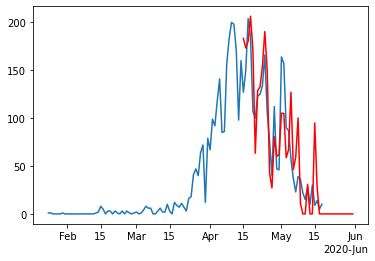

In [8]:
# 予測とプロット

pred = best_fit.predict('2020-04-15', '2020-05-31')

# 負の予測値は0にしておく
pred[pred < 0] = 0

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax.clear()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(df['date'], df['confirmed'])
ax.plot(pred.index, pred, 'r')

plt.savefig('plot.png')